#### OBJETIVO: Procesamiento de variable de ERA5 correspondiente a las variables metereologica

In [6]:
#Library
import os
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import netCDF4
from functools import reduce
print("librerias")

librerias


In [2]:
# Leer dataset donde se encuetnran las coordenadas de las estaciones de monitoreo
estacion = "SP"
year = 2015
numRaster = "01"

stations = pd.read_csv(
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/estaciones/sitios_{estacion}.csv", encoding="latin-1"
)

stations = stations[
    #(stations["tipo"] == "referencia") &
    (stations["Considerado"] == "SI")
]

print(len(stations))

24


<xarray.DataArray (y: 64, x: 50)> Size: 13kB
[3200 values with dtype=float32]
Coordinates:
  * y            (y) float64 512B -23.35 -23.36 -23.37 ... -24.0 -24.01 -24.02
  * x            (x) float64 400B -46.88 -46.87 -46.86 ... -46.39 -46.37 -46.36
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3000.0
    scale_factor:   1.0
    add_offset:     0.0


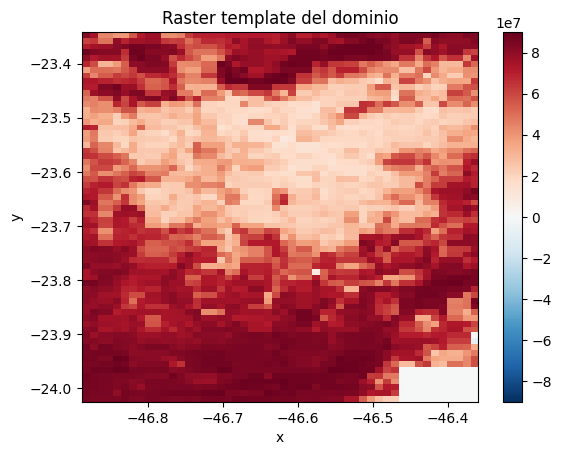

In [3]:
# Leer el template correspondiente al dominio
template = rioxarray.open_rasterio(
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/rasterTemplate/{numRaster}_raster_template.tif"
).squeeze()
print(template)


template.plot()
plt.title("Raster template del dominio")
plt.show()


In [4]:
### Listar NetCDF ERA5
year = 2015
base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/meteoSatelital/{year}"
# files = [f for f in os.listdir(base_dir) if f.endswith(".nc")]
files = []
for f in os.listdir(base_dir):
    if f.endswith(".nc"):
        files.append(f)
files



['2015-01-01_SP_download.nc',
 '2015-01-02_SP_download.nc',
 '2015-01-03_SP_download.nc']

In [5]:
# Variables seleccionadas para el analisis
variables = ["t2m", "d2m", "sp", "u10", "v10", "blh"]
# Tomar de cada archivo las variables predictivas
for nc_file in files:
    
    print(nc_file)
    
    path_nc = os.path.join(base_dir, nc_file)
    
    ds = xr.open_dataset(path_nc, engine="netcdf4")
    date_str = nc_file[:10]
   
    for var in variables:
        print(f"Procesando variable {var}")
        da = ds[var]

        era_rows = []

        # Loop horario
        for t in da.valid_time.values:
            da_t = da.sel(valid_time=t)

            timestamp = pd.to_datetime(str(t))
            hora = timestamp.strftime("%H:%M:%S")

            # Reproyección
            da_proj = da_t.rio.write_crs("EPSG:4326", inplace=True)
            da_proj = da_proj.rio.reproject_match(template)

            # Extraer valores en estaciones
            for _, row in stations.iterrows():
                value = da_proj.sel(
                    x=row["long"],
                    y=row["lat"],
                    method="nearest"
                ).values.item()

                era_rows.append({
                    "date": date_str,
                    "fecha": timestamp,
                    "hora": hora,
                    "nombre_var": var,
                    "unidad": da.attrs.get("units", ""),
                    "valor": value,
                    "estacion": row["estacion"],
                    "ID": row["ID"]
                })

        era_df = pd.DataFrame(era_rows)

        # Guardar CSV
        #out_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/proceed/05_ERA5/V03/{year}/{var}"
        #os.makedirs(out_dir, exist_ok=True)

        #out_name = f"{out_dir}/{nc_file}_{var}.csv"
        #era_df.to_csv(out_name, index=False)

        #print(f"Guardado {out_name}")
print(era_df)

2015-01-01_SP_download.nc
Procesando variable t2m
Procesando variable d2m
Procesando variable sp
Procesando variable u10
Procesando variable v10
Procesando variable blh
2015-01-02_SP_download.nc
Procesando variable t2m
Procesando variable d2m
Procesando variable sp
Procesando variable u10
Procesando variable v10
Procesando variable blh
2015-01-03_SP_download.nc
Procesando variable t2m
Procesando variable d2m
Procesando variable sp
Procesando variable u10
Procesando variable v10
Procesando variable blh
           date               fecha      hora nombre_var unidad       valor  \
0    2015-01-03 2015-01-03 00:00:00  00:00:00        blh      m   57.506714   
1    2015-01-03 2015-01-03 00:00:00  00:00:00        blh      m   60.723511   
2    2015-01-03 2015-01-03 00:00:00  00:00:00        blh      m   57.506714   
3    2015-01-03 2015-01-03 00:00:00  00:00:00        blh      m   77.590698   
4    2015-01-03 2015-01-03 00:00:00  00:00:00        blh      m   77.590698   
..          ...    

In [ ]:
## Procesamiento post extraccion datos donde solo agarramos algunos datos

# -----------------------------
# Parametros
# -----------------------------
tipo = ["u10"]     
estacion = "CH"
year = 2024

# Horas seleccionadas ver-revisar
horas_subt = [
    "12:00:00", "13:00:00", "14:00:00",
    "15:00:00", "16:00:00", "17:00:00"
]

# -----------------------------
# Loop por variable
# -----------------------------
for var in tipo:
    print("--------------------")
    print(var)
    print("--------------------")

    dire = (
        f"D:/Josefina/Proyectos/ProyectoChile/"
        f"{estacion}/proceed/05_ERA5/V03/{year}/{var}"
    )

    files = [
        f for f in os.listdir(dire)
        if f.endswith(".csv")
    ]

    df_rbind = []

    # -----------------------------
    # Loop por archivos CSV
    # -----------------------------
    for i, fname in enumerate(files, start=1):
        print(i)

        path = os.path.join(dire, fname)
        data = pd.read_csv(path)

        # Eliminar NA en valor
        data = data.dropna(subset=["valor"])

        # ID estacion
        ID = data.loc[0, "ID"]

        # Fecha
        data["date"] = pd.to_datetime(
            data["fecha"]
        ).dt.date

        # Subconjunto horarios especificos
        data_subt = data[
            data["hora"].isin(horas_subt)
        ]

        # -----------------------------
        # Agrupacion diaria
        # -----------------------------
        df = (
            data
            .groupby(["estacion", "ID", "date"])
            .agg(
                nombre_var=("nombre_var", "first"),
                unidad=("unidad", "first"),
                mean=("valor", "mean"),
                min=("valor", "min"),
                max=("valor", "max"),
                sd=("valor", "std"),
                n=("valor", "count")
            )
            .reset_index()
        )

        # Media en horas subt (por dia y estacion)
        mean_subt = (
            data_subt
            .groupby(["estacion", "ID", "date"])["valor"]
            .mean()
            .reset_index(name="mean_subt")
        )

        # Merge para replicar R
        df = df.merge(
            mean_subt,
            on=["estacion", "ID", "date"],
            how="left"
        )

        df_rbind.append(df)

    # -----------------------------
    # Concatenar todo
    # -----------------------------
    df_rbind = pd.concat(df_rbind, ignore_index=True)

    # -----------------------------
    # Guardar CSV
    # -----------------------------
    out_name = (
        f"D:/Josefina/Proyectos/ProyectoChile/"
        f"{estacion}/proceed/05_ERA5/V03/tot/"
        f"{var}_{year}_dia.csv"
    )

    df_rbind.to_csv(out_name, index=False)

# Resultados
print("Filas totales:", len(df_rbind))
df_rbind.head()


In [ ]:
# Unir todos los CSV de una variable (equivalente a rbind)

estacion = "CH"
tipo = "tp"

dire = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/proceed/05_ERA5/tot/{tipo}"

files = [f for f in os.listdir(dire) if f.endswith(".csv")]

dfs = []

for i, f in enumerate(files, start=1):
    print(i)
    df = pd.read_csv(os.path.join(dire, f))
    print(len(df))
    dfs.append(df)

df_rbind = pd.concat(dfs, ignore_index=True)

out = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/proceed/05_ERA5/tot/{tipo}_{estacion}_dia.csv"
df_rbind.to_csv(out, index=False)


In [ ]:
#Leer datasets diarios por variable y renombrar columnas
# A diferencia del r lo hacemos funcion
def read_var(path, var):
    df = pd.read_csv(path)

    df["date"] = pd.to_datetime(df["date"]).dt.date
    df = df[df["ID"] != 0]

    return df[[
        "date", "estacion", "ID",
        "mean", "min", "max", "sd", "n", "mean_subt"
    ]].rename(columns={
        "mean": f"mean_{var}",
        "min": f"min_{var}",
        "max": f"max_{var}",
        "sd": f"sd_{var}",
        "n": f"n_{var}",
        "mean_subt": f"mean_subt_{var}",
    })


#### Correr funcion
base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/proceed/05_ERA5/V03/tot"
year = 2024

data_blh = read_var(f"{base_dir}/blh_{year}_dia.csv", "blh")
data_d2m = read_var(f"{base_dir}/d2m_{year}_dia.csv", "d2m")
data_sp  = read_var(f"{base_dir}/sp_{year}_dia.csv",  "sp")
data_t2m = read_var(f"{base_dir}/t2m_{year}_dia.csv", "t2m")
data_tp  = read_var(f"{base_dir}/tp_{year}_dia.csv",  "tp")
data_u10 = read_var(f"{base_dir}/u10_{year}_dia.csv", "u10")
data_v10 = read_var(f"{base_dir}/v10_{year}_dia.csv", "v10")


In [ ]:


dfs = [
    data_blh, data_d2m, data_sp,
    data_t2m, data_tp, data_u10, data_v10
]

merged_df = reduce(
    lambda left, right: pd.merge(
        left, right, on=["ID", "date"], how="left"
    ),
    dfs
)


In [ ]:
#Generar el dataset final
final_df = merged_df[[
    "date", "ID", "estacion",

    "mean_blh", "min_blh", "max_blh", "sd_blh", "mean_subt_blh",
    "mean_sp",  "min_sp",  "max_sp",  "sd_sp",  "mean_subt_sp",
    "mean_d2m", "min_d2m", "max_d2m", "sd_d2m", "mean_subt_d2m",
    "mean_t2m", "min_t2m", "max_t2m", "sd_t2m", "mean_subt_t2m",
    "mean_u10", "min_u10", "max_u10", "sd_u10", "mean_subt_u10",
    "mean_v10", "min_v10", "max_v10", "sd_v10", "mean_subt_v10",
    "mean_tp",  "min_tp",  "max_tp",  "sd_tp",  "mean_subt_tp",
]]

#Proceamiento posterior del dataset

final_df = final_df.drop_duplicates()
final_df = final_df.dropna(subset=["mean_blh"])


In [ ]:
# Unir todas las estaciones
dir_all = "D:/Josefina/Proyectos/ProyectoChile/dataset/meteoSatelital"

files = [f for f in os.listdir(dir_all) if f.endswith(".csv")]

dfs = []
for i, f in enumerate(files, start=1):
    print(i)
    dfs.append(pd.read_csv(os.path.join(dir_all, f)))

data_all = pd.concat(dfs, ignore_index=True)
data_all.to_csv("08_tot_data_meteo_sat_dia.csv", index=False)


In [ ]:
# Chequeo de duplicados
data_blh.groupby(["date", "ID"]).size().reset_index(name="count").query("count > 1")
data_d2m.groupby(["date", "ID"]).size().reset_index(name="count").query("count > 1")
# ver resto